In [11]:
from game import WordleGame
from solver import *
from solver import _check_valid_word
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator

%matplotlib inline

%config InlineBackend.figure_format='retina'

In [2]:
N = len(words)
N

2315

# Turn-Target Matrix

We define an $N\times N$ matrix, $\pi$, where $\pi_{ij}$ is the 5-long result from guessing word $i$ when word $j$ was the target word. 

In [3]:
pi = np.zeros(shape=(N, N, 5))

In [4]:
for j in trange(N):
    w = WordleGame(word=words[j])
    for i in range(N):
        if words[i] == words[j]: # we're testing the target word
            pi[i,j] = np.ones(5)
        else:
            pi[i,j] = w.turn(words[i])

100%|██████████| 2315/2315 [00:25<00:00, 89.46it/s]


## Solver 

After every turn:

1. Get indices of remaining valid words.
2. Take the index of $\tau=$`pi.sum(axis=2)` with the greatest sum along either axis 0 or 1 (they should be the same). This corresponds to the word which maximizes the expected value of information gained from the turn.

3. Update letter and word masks. For the word mask, zero out the entire row and column of $\tau$ if a word is no longer possible.

In [47]:
def update_word_mask(word_mask, letter_mask, poss):
    """Update word mask based on guess."""
    for i, w in enumerate(words):
        if not _check_valid_word(w, letter_mask, poss):
            word_mask[i, :] = np.zeros(N)
            word_mask[:, i] = np.zeros(N)
    
    return word_mask


def maximum_information_solver(game, tau):
    """Solve game using maximum information strategy."""
    word_mask = np.ones(shape=(N, N)) # 1 means word is still valid, 0 means it's not
    letter_mask = ["."] * 5 # mask for each letter
    poss = set() # required letters
    while not game.solved:
        # reduce tau by elementwise multiplying by word_mask
        tau = np.multiply(tau, word_mask)
        # get index with highest sum (we could use average but that's just divide by N)
        word_idx = np.argmax(tau.sum(axis=0))
        # make move using this word
        guess = words[word_idx]
        result = game.turn(guess)
        # update masks based on result
        letter_mask, poss = update_mask(result, guess, letter_mask, poss)
        word_mask = update_word_mask(word_mask, letter_mask, poss)
    
    return game.score

## Simulation

Compare this solver against the baseline elimination (random picking from narrowed word list).

In [35]:
tau = pi.sum(axis=2)

In [27]:
np.argmax((tau - tau.T).flatten()) // 2315

2137

In [29]:
words[2137]

'mamma'

In [48]:
from joblib import Parallel, delayed


def play_vs(target_word):
    """Compare elimination solver to MI solver."""
    w = WordleGame(word=target_word)
    # elim solver goes first
#     elim_solver_score = elimination_solver(w)
#     elim_solver_score = maximum_information_solver(w, tau, 0)
    elim_solver_score = maximum_information_solver(w, tau, explore_start=True)
    # reset and try MI solver
    w.reset()
    mi_solver_score = maximum_information_solver(w, tau)
    return elim_solver_score, mi_solver_score

scores = Parallel(n_jobs=-1, verbose=2)(delayed(play_vs)(tw) for tw in words)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2315 out of 2315 | elapsed:  4.7min finished


/home/arunavgupta/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


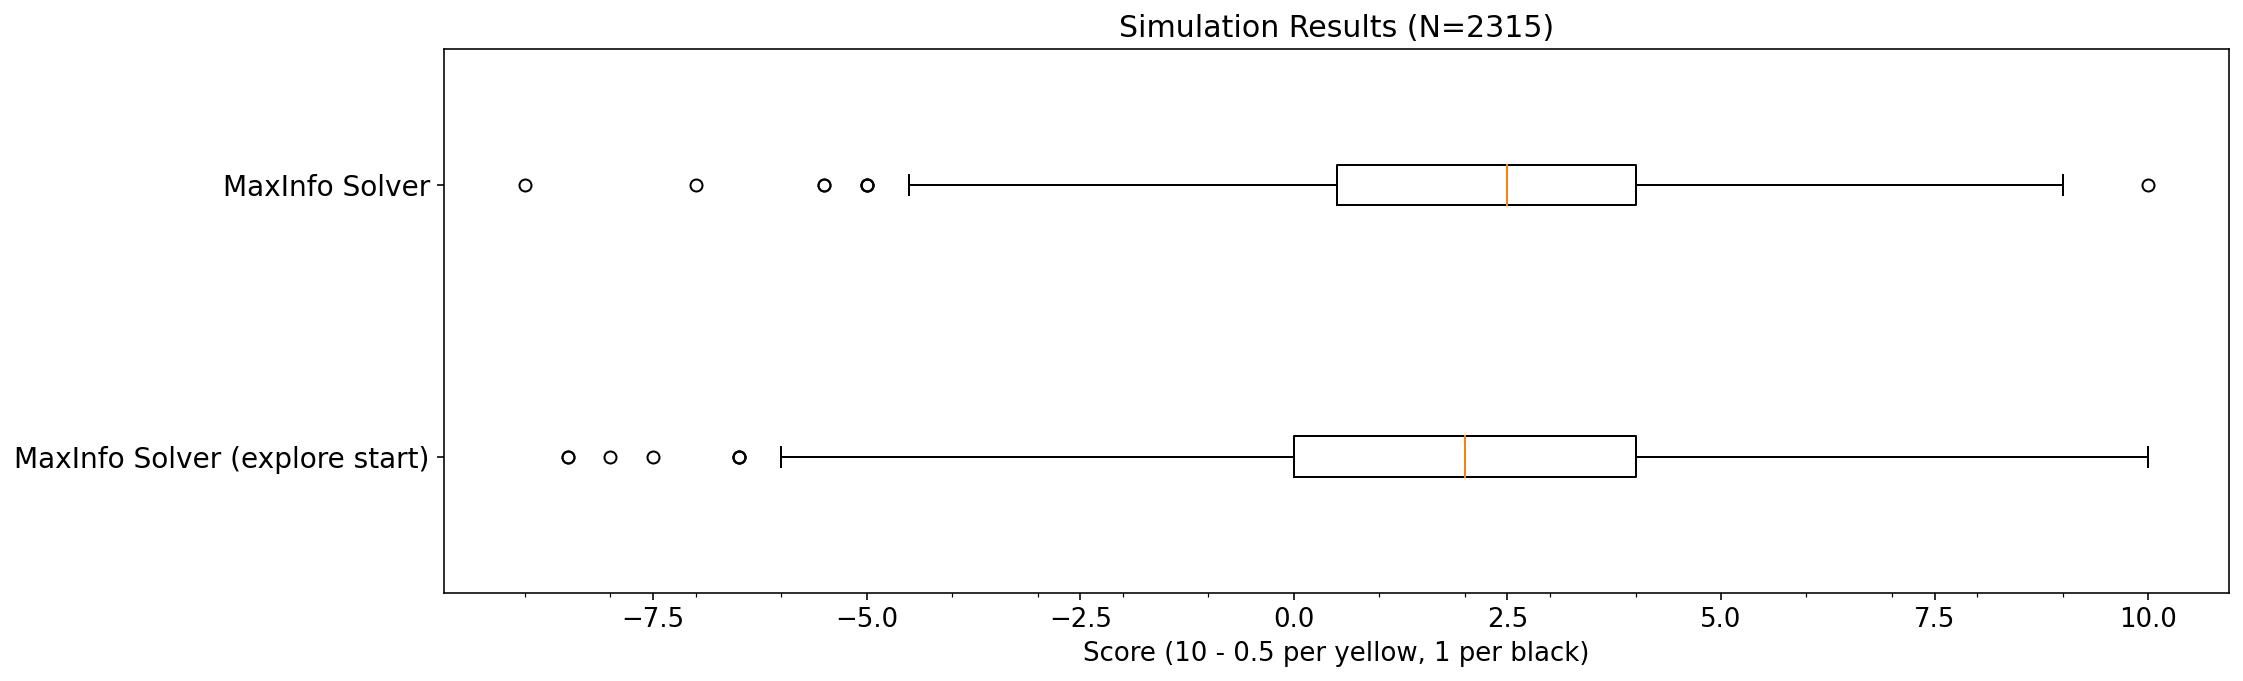

In [49]:
plt.figure(figsize=(16, 5))
plt.boxplot(list(map(list, zip(*scores))), vert=False)
plt.yticks([1, 2], ['MaxInfo Solver (explore start)', 'MaxInfo Solver'], fontsize=14)
plt.xticks(fontsize=13)
# plt.tick_params(axis='x', which='minor', bottom=True)
# plt.minorticks_on()
plt.axes().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel("Score (10 - 0.5 per yellow, 1 per black)", fontsize=13)
plt.title("Simulation Results (N=2315)", fontsize=15)
plt.savefig("maxinfo_results.png", facecolor='white')

In [50]:
sum(map(lambda x: x[0], scores)) / 2315

1.9010799136069114

In [57]:
# steps = []
# tau = build_tau(words)
# for word in tqdm(words):
#     game = WordleGame(word=word)
#     score = maximum_information_solver(game, tau)
#     steps.append(game.curr_step)
    
def play_vs_steps(target_word):
    game = WordleGame(word=target_word)
    maximum_information_solver(game, tau, explore_start=True)
    explore_steps = game.curr_step
    game.reset()
    maximum_information_solver(game, tau)
    std_steps = game.curr_step
    return explore_steps, std_steps
    
steps = Parallel(n_jobs=-1, verbose=2)(delayed(play_vs_steps)(tw) for tw in words)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2315 out of 2315 | elapsed:  4.7min finished


In [52]:
w = WordleGame('catch', verbose=2)
maximum_information_solver(w, tau, explore_start=True)

erase => ⬛ ⬛ 🟨 ⬛ ⬛
talon => 🟨 🟩 ⬛ ⬛ ⬛
patch => ⬛ 🟩 🟩 🟩 🟩
watch => ⬛ 🟩 🟩 🟩 🟩
batch => ⬛ 🟩 🟩 🟩 🟩
match => ⬛ 🟩 🟩 🟩 🟩
hatch => 🟨 🟩 🟩 🟩 🟩
catch => 🟩 🟩 🟩 🟩 🟩
Wordle solved in 8 steps. Score: -2.5


-2.5

In [58]:
steps_explore = list(map(lambda x: x[0], steps))
steps_exploit = list(map(lambda x: x[1], steps))
step_explore_cdf = [np.sum(np.array(steps_explore) <= i) / N for i in range(max(steps_explore) + 1)]
step_exploit_cdf = [np.sum(np.array(steps_exploit) <= i) / N for i in range(max(steps_exploit) + 1)]

In [61]:
min(steps_exploit)

1

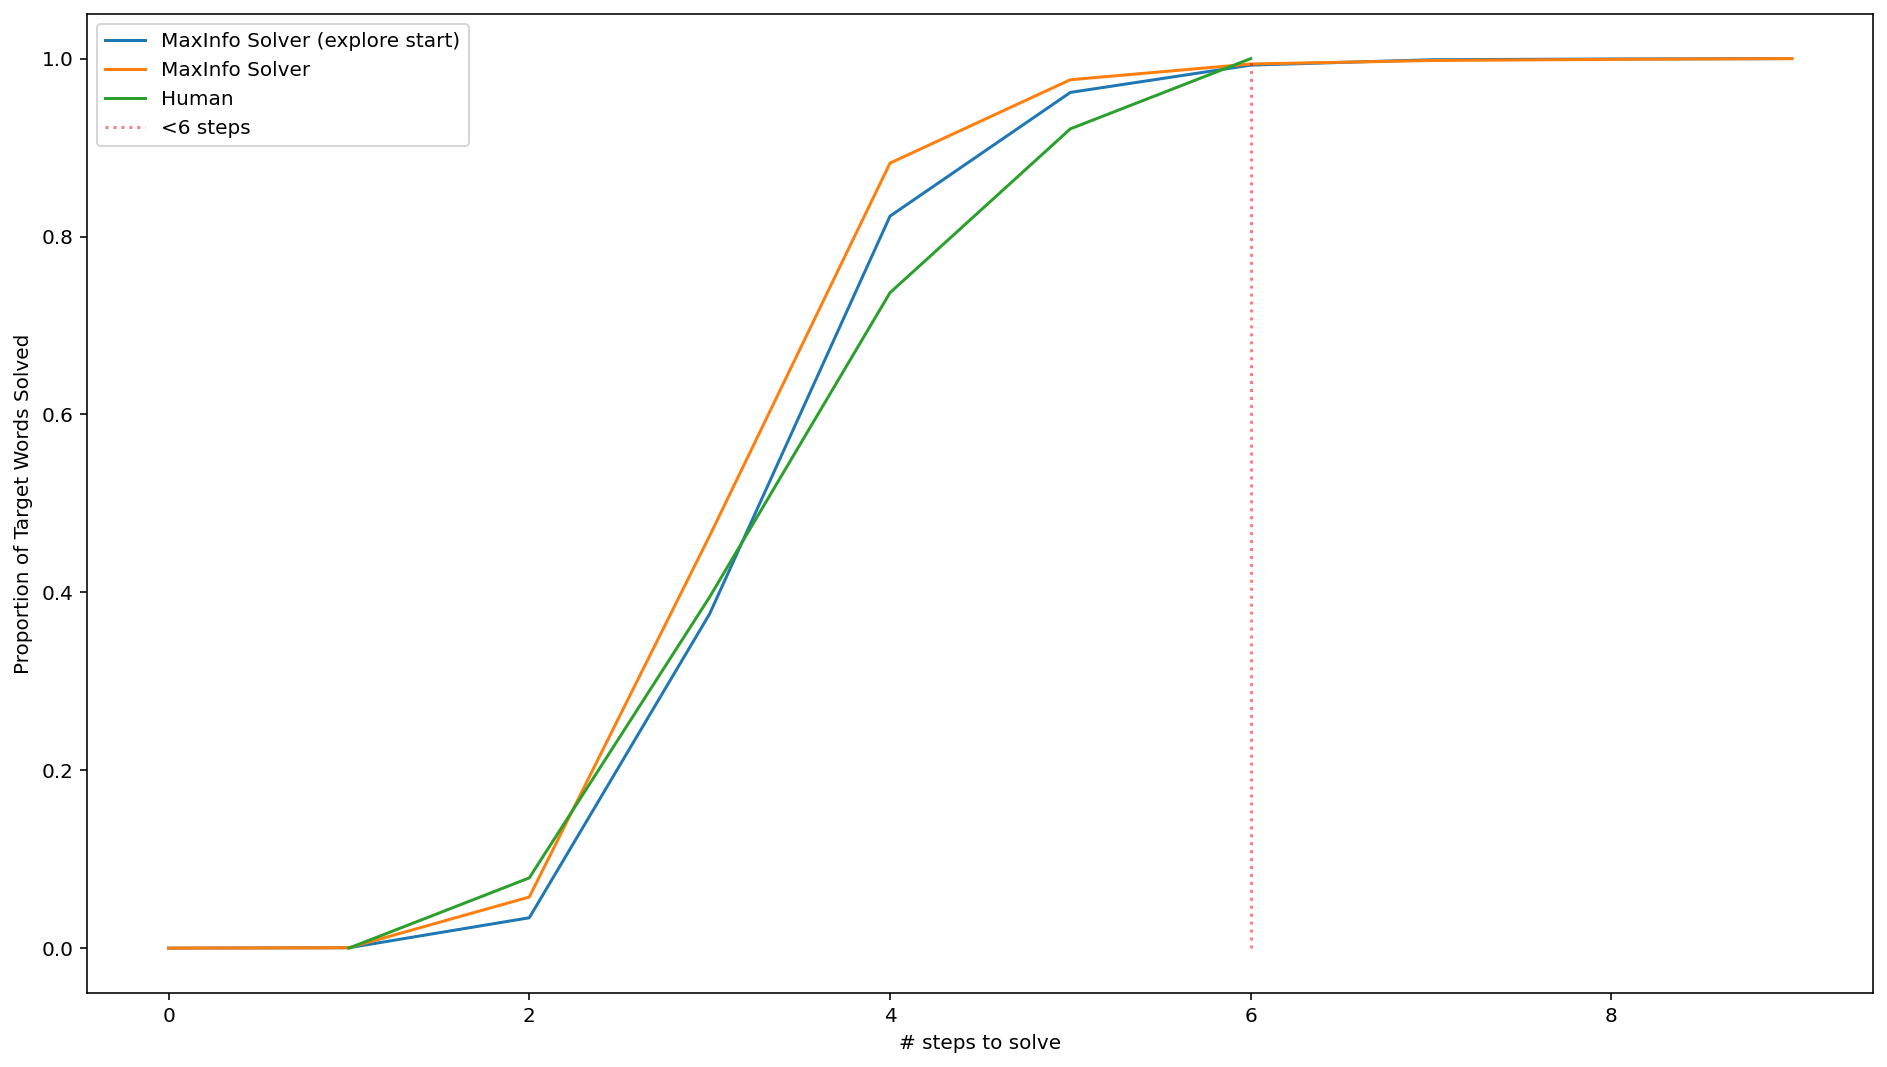

In [62]:
plt.figure(figsize=(16, 9))
plt.xlabel("# steps to solve")
plt.ylabel("Proportion of Target Words Solved")
plt.plot(step_explore_cdf, label='MaxInfo Solver (explore start)')
plt.plot(step_exploit_cdf, label='MaxInfo Solver')
plt.plot([1, 2, 3, 4, 5, 6], [0, 6/76, 30/76, 56/76, 70/76, 76/76], label='Human')
plt.plot([6, 6], [0, 1], alpha=0.5, c='r', linestyle=':', label='<6 steps')
plt.legend()